# Setup
* **Model:** `gpt2-xl` (1.5 B params).
* **Device routing:** run all heavy operations on GPU 0 when available; otherwise use CPU.
* **Tokenizer:** converts raw text to integer IDs so the model can “read” the tokens.

In [1]:
import tensorflow as tf
from transformers import (
    AutoTokenizer,
    TFAutoModelForCausalLM,
)
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# Use GPU 0 if available; otherwise fall back to CPU
tf_device = "/GPU:0" if tf.config.list_physical_devices("GPU") else "/CPU:0"
model_name = "gpt2-xl"   # 1.5 B params; ships only with PT weights ➜ convert on load, trained up to 2019
tokenizer  = AutoTokenizer.from_pretrained(model_name)
with tf.device(tf_device):
    model = TFAutoModelForCausalLM.from_pretrained(model_name, from_pt=True)
    model.config.eos_token_id = tokenizer.eos_token_id  # (helps suppress warnings)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


# Greedy Search Decoding
Greedy search decoding is the most simple method to generate tokens from a model's continuous output. It greedily selects the token with the highest probability at each timestep.



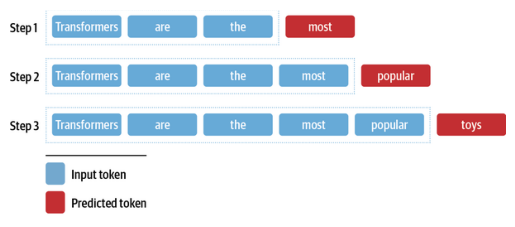

In [2]:
img_path = "greedy.png"
img = Image.open(img_path)

plt.imshow(img)
plt.axis("off")
plt.show()

## Implementing the decoding method `generate()`

### Prompt Encoding
Use a tokenizer to encode the prompt, turning the input into integers that the model is able to read.

In [3]:
input_txt = "Seattle Seahawks 2019"
input_ids = tokenizer(input_txt, return_tensors="tf").input_ids # shape (1, seq_len)

### Greedy Loop
1. **Forward pass:** Run the model on the input to obtain logits for every position; we only care about the newest (last) position.
2. Apply `softmax` to the final-position logits, turning raw scores into a probability distribution over the entire vocabulary.
3. **Top-k inspection:** Sort the probability distribution once (high → low) and keep the five most-likely tokens for visibility/auditing; we won’t sample from them.
4. **Trace logging:** Save the current prompt plus these five contenders so we can later audit what the model almost chose at each step.
5. **Greedy step:** Append the single highest-probability token (rank #1) to input_ids, making the prompt one token longer; then repeat from step 1.

In [4]:
# Greedy decoding parameters
n_steps = 100 # how many output tokens to generate
choices_per_step = 5 # how many token options per step
iterations = [] # use to log results

# Greedy loop: one token at a time
for _ in range(n_steps):
    # 1. Run forward pass through the LM with the current context/token string
    with tf.device(tf_device):
        output = model(input_ids, training=False)

    # 2. Convert logits of the last position into softmax probabilities for the next token
    next_token_logits = output.logits[:, -1, :] # shape (1, vocab)
    next_token_probs = tf.nn.softmax(next_token_logits, axis=-1)[0]  # (vocab,)

    # 3. Rank tokens by probability (highest prob --> lowest and keep the top-k for logging
    sorted_ids = tf.argsort(next_token_probs, direction="DESCENDING")
    topk_ids = sorted_ids[:choices_per_step].numpy()

    # 4. Record the current prompt and its five most-likely continuations
    iteration = {"Input": tokenizer.decode(input_ids[0])}
    for idx, tok_id in enumerate(topk_ids, start=1):
        prob = float(next_token_probs[tok_id])
        tok = tokenizer.decode([tok_id])
        iteration[f"Choice {idx}"] = f"{tok} ({100*prob:.2f}%)"
    iterations.append(iteration)

    # 5. Append the most-likely token to continue generation
    best_id = topk_ids[0]
    input_ids = tf.concat([input_ids, [[best_id]]], axis=-1)

# Convert the log to a dataframe for inspection
df = pd.DataFrame(iterations)
print(df)

                                                                                                                                                                                                                                                                                                                                                                                                                                      Input  \
0                                                                                                                                                                                                                                                                                                                                                                                                                     Seattle Seahawks 2019   
1                                                                                                                                         

## Shortcut version using `model.generate()`
* Everything that happened in the manual loop (soft-max --> arg-max --> token-append --> repeat) is wrapped inside the `model.generate()` function.
* Setting `do_sample=False` keeps the exact same greedy policy, while `max_new_tokens` controls how many tokens to add.
* This one-liner is easier to maintain and can switch to more advanced decoders later (top-p, beam, etc...) just by flipping the flags.

The main drawback to greedy decoding is that the local "best choices" it makes often lead to sub optimal sequences. Therefore, Greedy search decoding is rarely used for large text generation tasks that require diversity.

In [5]:
prompt = "Seattle Seahawks 2019"
prompt_ids = tokenizer(input_txt, return_tensors="tf").input_ids # shape (1, seq_len)
prompt_len = prompt_ids.shape[1]
n_steps = 128

In [6]:
with tf.device(tf_device):
    output_ids = model.generate(
        prompt_ids,
        max_new_tokens=n_steps,
        do_sample=False
    )

# Decode the full prompt and its continuation back into plain text using tokenizer.decode
print(tokenizer.decode(output_ids[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Seattle Seahawks 2019

The Seahawks have a lot of work to do to get back to the Super Bowl, but they have a lot of talent on the roster. They have a lot of young talent, and they have a lot of potential. They have a lot of potential to be a Super Bowl contender.

The Seahawks have a lot of work to do to get back to the Super Bowl, but they have a lot of talent on the roster. They have a lot of young talent, and they have a lot of potential. They have a lot of potential to be a Super Bowl contender.

The Seahawks have a lot of work to


Greedy is helpful, though, for producing short sequences like arithmetic sequences where a deterministic and factually correct output is preferred. Example input: "5 + 8 => 13 \n 7 + 2 => 9 \n 1 + 0 =>"

In [7]:
alg_txt = "15 + 28 => 43 \n 7 + 2 => 9 \n 11 + 42 =>"
alg_ids = tokenizer(input_txt, return_tensors="tf").input_ids # shape (1, seq_len)
temp_n_steps = 1

with tf.device(tf_device):
    alg_output_ids = model.generate( # ensure tensor operations stay on the chosen GPU/CPU
        alg_ids, # tensor of prompt IDs (shape: [1, prompt_len])
        max_new_tokens=temp_n_steps, # add 128 new tokens after the inputted prompt
        do_sample=False # OFF = greedy: at each step pick arg-max(logits). Setting to true enables sampling-based decoders.
    )

# Decode the full prompt and its continuation back into plain text using tokenizer.decode
print(tokenizer.decode(alg_output_ids[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Seattle Seahawks 2019



# Beam Search Decoding

Greedy decoding grabs the single highest-probability token each step, which is fast but shortsighted.  
**Beam search** keeps the top-`B` partial sequences (“beams”), expands each by
_one_ token, then prunes back to `B`. Doing this repeatedly explores a wider
portion of the probability tree and often finds higher-probability sentences.

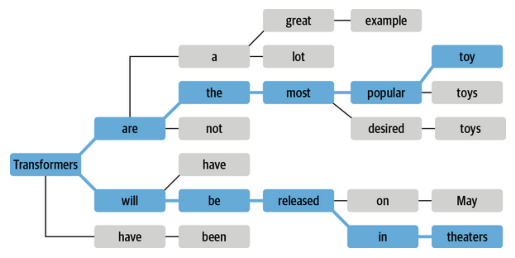

In [8]:
img_path = "beam.png"
img = Image.open(img_path)

plt.imshow(img)
plt.axis("off")
plt.show()

### Calculating and comparing the log probabilities of texts generated by greedy and beam search to see if beam can improve the overall probability.

In [9]:
def log_probs_from_logits(logits, labels):
    logp = tf.nn.log_softmax(logits, axis=-1)
    labels_exp = tf.expand_dims(labels, axis=-1)
    logp_token = tf.gather_nd(logp, tf.concat(
        [tf.repeat(tf.range(tf.shape(labels)[0])[:, None], tf.shape(labels)[1], axis=1)[..., None],
         tf.expand_dims(tf.range(tf.shape(labels)[1]), axis=0)[:, :, None],
         labels_exp], axis=-1))
    return logp_token

In [10]:
def sequence_logprob(model, seq_ids, prompt_len=0):
    with tf.device(tf_device):
        outputs = model(seq_ids, training=False)
    logp = log_probs_from_logits(outputs.logits[:, :-1, :], seq_ids[:, 1:])
    return tf.reduce_sum(logp[:, prompt_len:]).numpy()

### Greedy decoding (baseline)

In [11]:
with tf.device(tf_device):
    greedy_ids = model.generate(
        prompt_ids,
        max_length=n_steps,
        do_sample=False
    )

greedy_text = tokenizer.decode(greedy_ids[0])
greedy_lp = sequence_logprob(model, greedy_ids, prompt_len)

print(greedy_text)
print(f"\nGreedy log-prob: {greedy_lp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Seattle Seahawks 2019

The Seahawks have a lot of work to do to get back to the Super Bowl, but they have a lot of talent on the roster. They have a lot of young talent, and they have a lot of potential. They have a lot of potential to be a Super Bowl contender.

The Seahawks have a lot of work to do to get back to the Super Bowl, but they have a lot of talent on the roster. They have a lot of young talent, and they have a lot of potential. They have a lot of potential to be a Super Bowl contender.

The Seahawks have a lot

Greedy log-prob: -74.42


### Beam Search Decoding (5 beams)
The only change is the `num_beams` parameter. The more beams, the better the results and the slower it takes to generate the results (multiple sequences are being generated in parallel).

In [12]:
with tf.device(tf_device):
    beam_ids = model.generate(
        prompt_ids,
        max_length=n_steps,
        num_beams=5,
        do_sample=False
    )

beam_text = tokenizer.decode(beam_ids[0])
beam_lp = sequence_logprob(model, beam_ids, prompt_len)

print(beam_text)
print(f"\n5-Beam log-prob: {beam_lp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Seattle Seahawks 2019 NFL Draft Pick Transactions

2018 NFL Draft Pick Transactions

2017 NFL Draft Pick Transactions

2016 NFL Draft Pick Transactions

2015 NFL Draft Pick Transactions

2014 NFL Draft Pick Transactions

2013 NFL Draft Pick Transactions

2012 NFL Draft Pick Transactions

2011 NFL Draft Pick Transactions

2010 NFL Draft Pick Transactions

2009 NFL Draft Pick Transactions

2008 NFL Draft Pick Transactions

2007 NFL Draft Pick Transactions

2006 NFL Draft Pick Transactions

2005 NFL Draft Pick Transactions

2004 NFL Draft Pick Transactions

2003 NFL Draft Pick Transactions

2002 NFL Draft Pick Transactions<|endoftext|><|endoftext|>

5-Beam log-prob: -27.56


There is a better log probability (higher is better) with beam search than with simple greedy decoding. However, beam search can also suffer from repetitive text. To address this, use an n-gram penalty with the `no_repeat_ngram_size` parameter that tracks which n-grams have been seen and sets the next probability to zero if it would produce a previously seen n-gram.

### 5-Beam Search + 2-gram repetition penalty
`no_repeat_ngram_size=2` blocks the model from producing any bigram it has
already emitted, cutting down on loops.

In [13]:
with tf.device(tf_device):
    beam_nr_ids = model.generate(
        prompt_ids,
        max_length=n_steps,
        num_beams=5,
        do_sample=False,
        no_repeat_ngram_size=2
    )

beam_nr_text = tokenizer.decode(beam_nr_ids[0])
beam_nr_lp = sequence_logprob(model, beam_nr_ids, prompt_len)

print(beam_nr_text)
print(f"\nlog-prob (beam=5, no-repeat 2-gram): {beam_nr_lp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Seattle Seahawks 2019 NFL Draft Picks

Round 1 (10) - Germain Ifedi, OT, Texas A&M (5-11, 305)
. . . Round 2 (47) DeShone Kizer, QB, Notre Dame (6-4, 220) .
, Round 3 (95) Shaquill Griffin, CB, UCF (4-10, 190) , Round 4 (140) Jordan Willis, DE, Kansas State (7-0, 245) Round 5 (180) Ryan Anderson, LB, Alabama (8-1, 255)<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>

log-prob (beam=5, no-repeat 2-gram): -226.30


In [15]:
with tf.device(tf_device):
    beam_temp_ids = model.generate(
        prompt_ids,
        max_length=n_steps,
        num_beams=5,
        do_sample=False,
        no_repeat_ngram_size=2,
        temperature=0.5,
        top_k=50,
        top_p=0.9
    )

beam_nr_text = tokenizer.decode(beam_nr_ids[0])
beam_nr_lp = sequence_logprob(model, beam_nr_ids, prompt_len)

print(beam_nr_text)
print(f"\nlog-prob (beam=5, no-repeat 2-gram): {beam_nr_lp:.2f}")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Seattle Seahawks 2019 NFL Draft Picks

Round 1 (10) - Germain Ifedi, OT, Texas A&M (5-11, 305)
. . . Round 2 (47) DeShone Kizer, QB, Notre Dame (6-4, 220) .
, Round 3 (95) Shaquill Griffin, CB, UCF (4-10, 190) , Round 4 (140) Jordan Willis, DE, Kansas State (7-0, 245) Round 5 (180) Ryan Anderson, LB, Alabama (8-1, 255)<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>

log-prob (beam=5, no-repeat 2-gram): -226.30
